# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

**Import Packages and Modules**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import datetime


**Visualize Where The Weather Stations Are**

In [2]:
#Read in the data as a CSV
df = pd.read_csv('data/C2A2_data/BinSize_d400.csv')

#Look for the correct file
station_locations_by_hash = df[df['hash'] == "fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89"]

#Locate the longitude and latitude of the stations
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

#Make a figure that's 8x8 (square)
plt.figure(figsize=(8,8))

#Plot a scatter plot of the locations
plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

#Display it on a map
mplleaflet.display()

**Read in the CSV and Look at the Data**

In [3]:
#Make Jypyter Notebook display matplotlib plots
%matplotlib notebook

#Read in the CSV
df = pd.read_csv("data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")

#Check the datatypes
print(df.dtypes)

#See the data we're dealing with
df.head()

ID            object
Date          object
Element       object
Data_Value     int64
dtype: object


,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


**Manipulate the Main Dataframe**

In [4]:
#Convert dates into datetime objects
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

#Sort the dataframe by dates
df.sort_values(by=["Date"], inplace = True)

#Create day and month columns from the datetime objects
df["Day"] = pd.DatetimeIndex(df["Date"]).day 
df["Month"] = pd.DatetimeIndex(df["Date"]).month 

#Set the multi-index as (Month, Day)
df.set_index(["Month", "Day"], inplace = True)

#Get rid of leap year date (Feb 29th)
df = df[~df.index.isin(df.loc[2,29].index)] 

#Convert temperatures into degrees celsius
df["Data_Value"] *= 0.1;

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.


**Create and Manipulate Dataframes for High and Low Temps**

In [5]:
#Create a new dataframe object to store the high temperatures
dfMAX = df[["Date", "Element", "Data_Value"]]

#Divide the data into 2005-2014 and 2015
dfMAX2015 = dfMAX.loc[dfMAX["Date"] >= "2015-01-01"]
dfMAX = dfMAX.loc[dfMAX["Date"] < "2015-01-01"]

#Boolean mask the 2005-2014 data to only keep the high and low temps
dfMIN = dfMAX.loc[dfMAX["Element"] == "TMIN"]
dfMAX = dfMAX.loc[dfMAX["Element"] == "TMAX"]  

#Boolean mask the 2015 data to only keep the high and low temps
dfMIN2015 = dfMAX2015.loc[dfMAX2015["Element"] == "TMIN"]
dfMAX2015 = dfMAX2015.loc[dfMAX2015["Element"] == "TMAX"] 

#Only keep the max and min temps of each day over 2005-2014 
max_temp = dfMAX.groupby(level = ["Month", "Day"])["Data_Value", "Date"].max()  
min_temp = dfMIN.groupby(level = ["Month", "Day"])["Data_Value", "Date"].min()

#Only keep the max and min temps of all weather stations day over 2015 
max_temp2015 = dfMAX2015.groupby(level = ["Month", "Day"])["Data_Value", "Date"].max()  
min_temp2015 = dfMIN2015.groupby(level = ["Month", "Day"])["Data_Value", "Date"].min()

#Only keep the 2015 data that is above or below the temperatures from 2005-2014
max_temp2015 = max_temp2015[max_temp2015["Data_Value"] > max_temp["Data_Value"]]
min_temp2015 = min_temp2015[min_temp2015["Data_Value"] < min_temp["Data_Value"]]

#Create a numpy array of datetime objects over a year
dates = np.arange("2015-01-01", "2016-01-01", dtype="datetime64[D]")
max_temp["Dates"] = dates
min_temp["Dates"] = dates

#Set the dates as the index (doing this to make the dates all the same year)
max_temp.set_index("Dates", inplace=True)
min_temp.set_index("Dates", inplace=True)

**Plotting and Formatting**

<IPython.core.display.Javascript object>


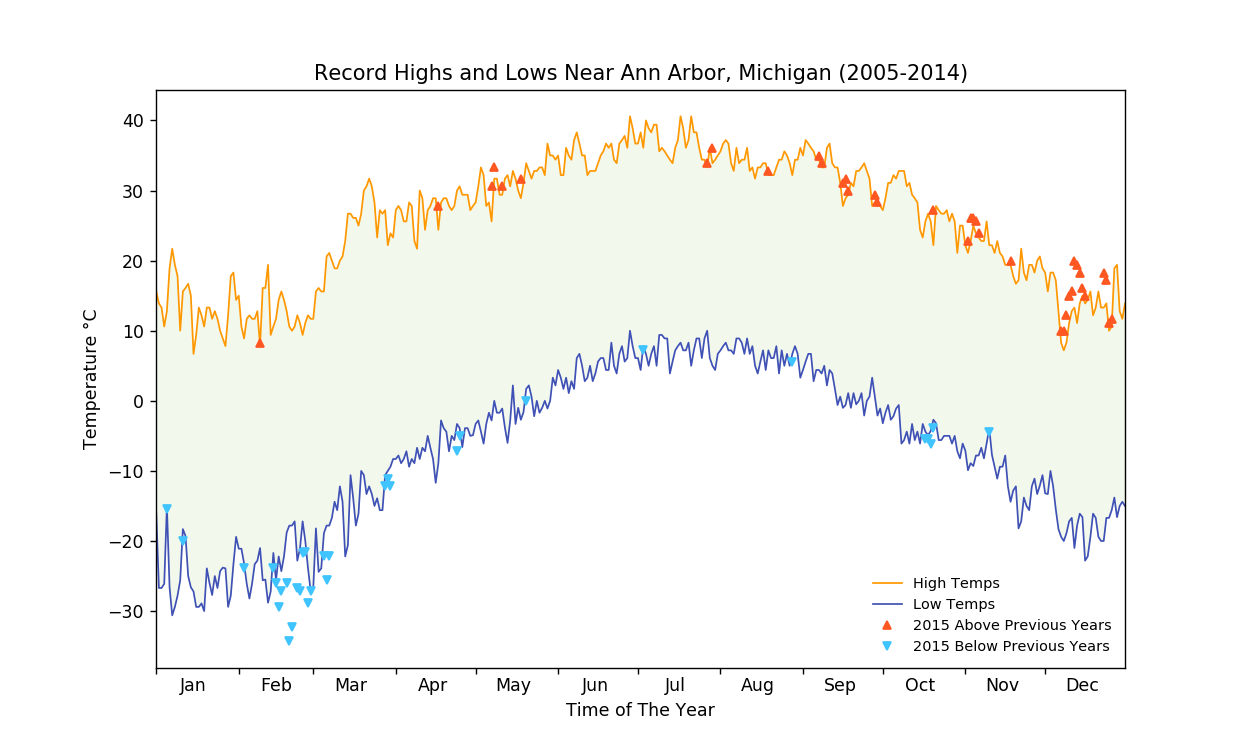

In [6]:
#Format the graph dates as month-date
fmt = mdates.DateFormatter('%m-%d')

#Make the figure 10 x 6 (aka more horizontal than vertical)
fig, ax = plt.subplots(figsize = (10, 6))

#Format the xaxis tickmarks so that the data is displayed as months with the labels in the middle
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

#Only show data for one year
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31)])

#Do not show the minor tickmarks
ax.tick_params(axis='x', which='minor', bottom=False)

#Uncomment below to put yaxis 
# ax.yaxis.grid(linewidth = 0.5) 

#Color pallette from http://materialcolors.com/

#Plot the line graph of the highs and lows (make the high temps orange and the low temps light blue)
ax.plot(max_temp.index, max_temp["Data_Value"], "#ff9800", linewidth=1, label = "High Temps")
ax.plot(min_temp.index, min_temp["Data_Value"], "#3f51b5", linewidth=1, label = "Low Temps")

#Fill in the space between the line graphs
ax.fill_between(min_temp.index, min_temp["Data_Value"], max_temp["Data_Value"], facecolor="#8bc34a", alpha = 0.1)

#Plot the scatter plot of the 2015 data with the markers as triangles
ax.plot(max_temp2015["Date"], max_temp2015["Data_Value"], "^", color = "#ff5722", markersize = 5, label = "2015 Above Previous Years")
ax.plot(min_temp2015["Date"], min_temp2015["Data_Value"], "v", color = "#40c4ff", markersize = 5, label = "2015 Below Previous Years")

#Create a legend without the frame
ax.legend(fontsize = "small", loc = "best", frameon = False)

#Set a title for the plot
ax.set_title("Record Highs and Lows Near Ann Arbor, Michigan (2005-2014)")

#Set the X-Axis label
plt.xlabel("Time of The Year")

#Create a variable to store the degree unicode
a = "\u00b0"

#Set the Y-Axis label
plt.ylabel("Temperature {}C".format(a))